In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

import downscale as down

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

# %run ../function/downscale_10km.ipynb

import warnings
warnings.filterwarnings('ignore')

## Downscaling for IMERG 3h in Veneto region - Automatic

In [2]:
# name, yy_s, yy_e = 'Coast Level', 2001, 2016
# name, yy_s, yy_e = 'Low Level', 2001, 2013
# name, yy_s, yy_e = 'Medium Level', 2001, 2016
name, yy_s, yy_e = 'High Level', 2001, 2022

maxmiss = 80

print(f'Station   : {name}')
print(f'Start year: {yy_s}')
print(f'End year  : {yy_e}')

Station   : High Level
Start year: 2001
End year  : 2022


In [3]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

## Haversine distance

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

def find_nearest_pixel(lon2d, lat2d, lon_c, lat_c):
    # Calculate the Euclidean distance between the rain gauge and each satellite pixel
    distance = np.sqrt((lon2d - lon_c)**2 + (lat2d - lat_c)**2)
    
    # Find the index of the minimum distance (nearest pixel)
    min_idx = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
    
    # Return the nearest pixel's indices and the corresponding latitude and longitude
    nearest_lat = lat2d[min_idx]
    nearest_lon = lon2d[min_idx]
    
    return min_idx, nearest_lat, nearest_lon

## LOAD IMERG DATA

In [5]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

time_vector = DATA['time'].data

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 618MB
Dimensions:  (time: 64280, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 514kB 2001-01-01 ... 2022-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 617MB 0.0 0.0 0.0 0.0 ... 4.27 4.56 0.0
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [6]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

In [7]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])

print(f'Original OBS S_time: {CL_RAIN['dataora'].values[0]}')
print(f'Original OBS E_time: {CL_RAIN['dataora'].values[len(CL_RAIN)-1]}')

CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year

CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
CL_RAIN.loc[CL_RAIN['valore'] > 200, 'valore'] = np.nan

CL_RAIN.set_index('dataora', inplace=True)

print()
print(f'New OBS S_time     : {CL_RAIN.index[0]}')
print(f'New OBS E_time     : {CL_RAIN.index[len(CL_RAIN)-1]}')

High Level station
Original OBS S_time: 1992-07-01T00:30:00.000000000
Original OBS E_time: 2023-01-01T00:00:00.000000000

New OBS S_time     : 2001-01-01 00:00:00
New OBS E_time     : 2022-12-31 23:30:00


## Convert OBS serie to daily acumm

In [8]:
OBS_daily = CL_RAIN['valore'].resample('D').sum()
OBS_NEW = pd.DataFrame({'TIME':OBS_daily.index, 'PRCP':OBS_daily.values})

## Create a manual time vector

In [9]:
TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
TIME_PD = pd.DataFrame({'TIME':TIME_REF})

In [10]:
len(OBS_daily), len(TIME_PD)

(8035, 8035)

## Verify the OBS and TRMM times

In [11]:
if len(OBS_daily) < len(TIME_REF):
    print('ERROR: OBS time is not complete. Verify data')
    OBS_NEW = pd.merge(OBS_NEW, TIME_PD, on='TIME', how='right')
elif len(OBS_daily) > len(TIME_REF):
    print('ERROR: OBS time has many times. Verify data')

## Convert OBS serie to xarray and Weibul parameters

In [12]:
OBS_xr = xr.DataArray(OBS_NEW['PRCP'].values,  coords={'time':OBS_NEW['TIME'].values}, dims=('time'))
NCW_OBS, YEARS_OBS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=maxmiss)

## Obtain the close TRMM pixel

In [13]:
RAIN_lat = CL_INFO['Lat'].values[0]
RAIN_lon = CL_INFO['Lon'].values[0]

In [14]:
# distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
# min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

nearest_pixel, nearest_lat, nearest_lon = find_nearest_pixel(lon2d, lat2d, RAIN_lon, RAIN_lat)

clat = lats[nearest_pixel[0]]
clon = lons[nearest_pixel[1]]

IMERG_ML = dset[:,nearest_pixel[0],nearest_pixel[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 46.14999771118164
Station lat       : 46.19073266

Nearest IMERG lon: 12.449999809265137
Station lon       : 12.40789032


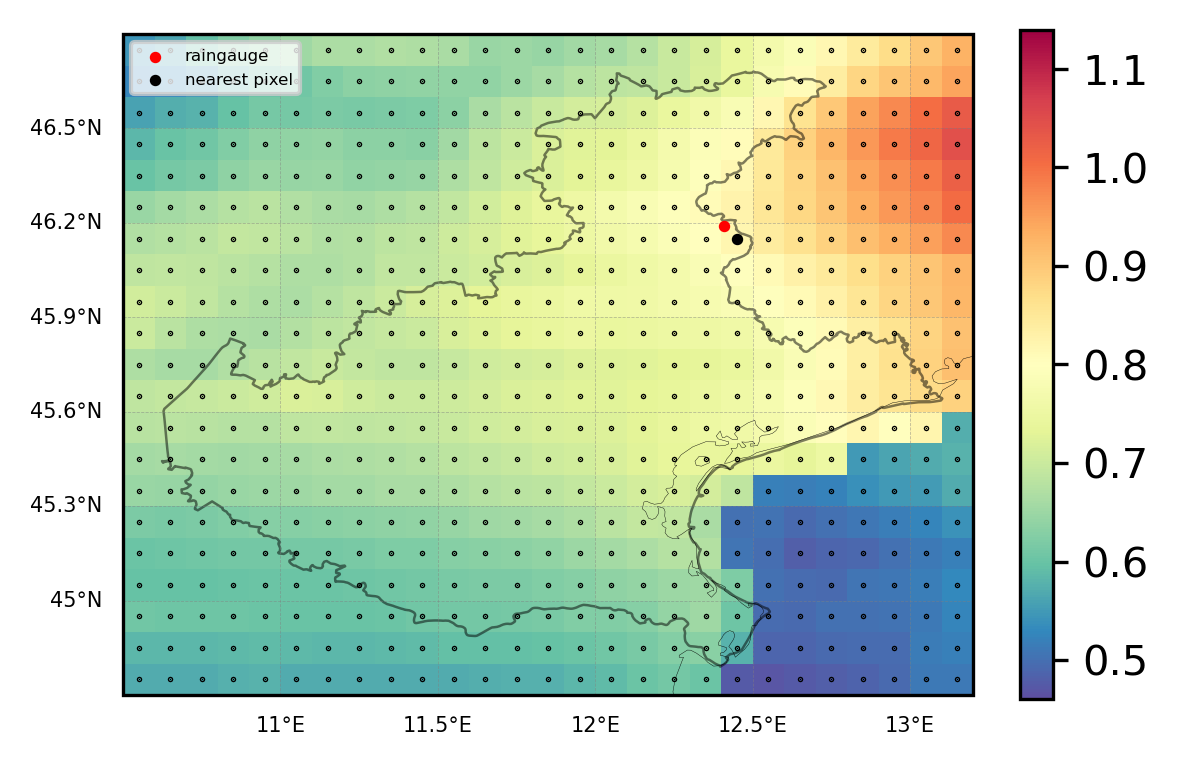

In [15]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=3, c='r', zorder=10, label='raingauge')
ax1.scatter(clon, clat, s=3, c='k', zorder=10, label='nearest pixel')

ax1.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

plt.colorbar(a1, fraction=0.036)

## Convert TRMM serie to xarray and Weibull parameters

In [16]:
IMERG_ML_xr = xr.DataArray(IMERG_ML,  coords={'time':time_vector}, dims=('time'))
IMERG_ML_xr = IMERG_ML_xr.resample(time ='1D').sum(dim='time', skipna=False)
NCW_IMERG, YEARS_IMERG = down.fit_yearly_weibull(IMERG_ML_xr, thresh=1, maxmiss=maxmiss)

In [17]:
bnds1 = np.where(~np.isnan(IMERG_ML_xr.data))[0]
IMERG_clear = IMERG_ML_xr.data[bnds1]
OBS_clear = OBS_xr.data[bnds1]

bnds2 = np.where(~np.isnan(OBS_clear))[0]
IMERG_clear = IMERG_clear[bnds2]
OBS_clear = OBS_clear[bnds2]

corr, _ = stats.spearmanr(IMERG_clear, OBS_clear)
corr = np.round(corr,2)
print(f'Daily correlation: {corr}')

Daily correlation: 0.6


Text(1.0, 1.0, 'Correlation: 0.6')

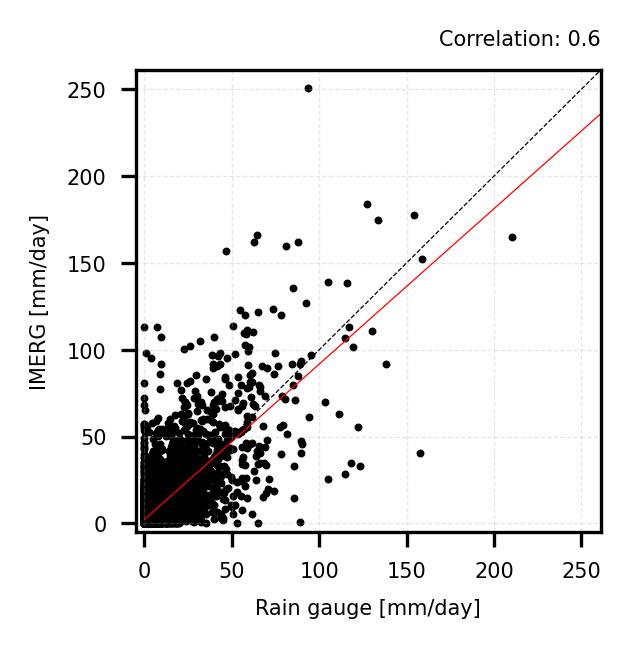

In [18]:
fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

xx = np.arange(len(IMERG_clear))
slope, intercept, _, _, _ = stats.linregress(OBS_clear, IMERG_clear)
max_limit = np.nanmax([np.nanmax(IMERG_clear), np.nanmax(OBS_clear)])

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(OBS_clear, IMERG_clear, s=0.8, color='k')

ax1.plot(xx,xx, linewidth=0.3, color='k', linestyle='--')
ax1.plot(xx,xx*slope+intercept, linewidth=0.3, color='r', linestyle='-')

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylabel('IMERG [mm/day]', fontsize=5)
ax1.set_xlabel('Rain gauge [mm/day]', fontsize=5)

ax1.set_xlim(-5, max_limit + 10)
ax1.set_ylim(-5, max_limit + 10)
ax1.grid(linewidth=0.3, linestyle='--', alpha=0.3)

ax1.set_title(f'Correlation: {corr}', fontsize=5, loc='right')

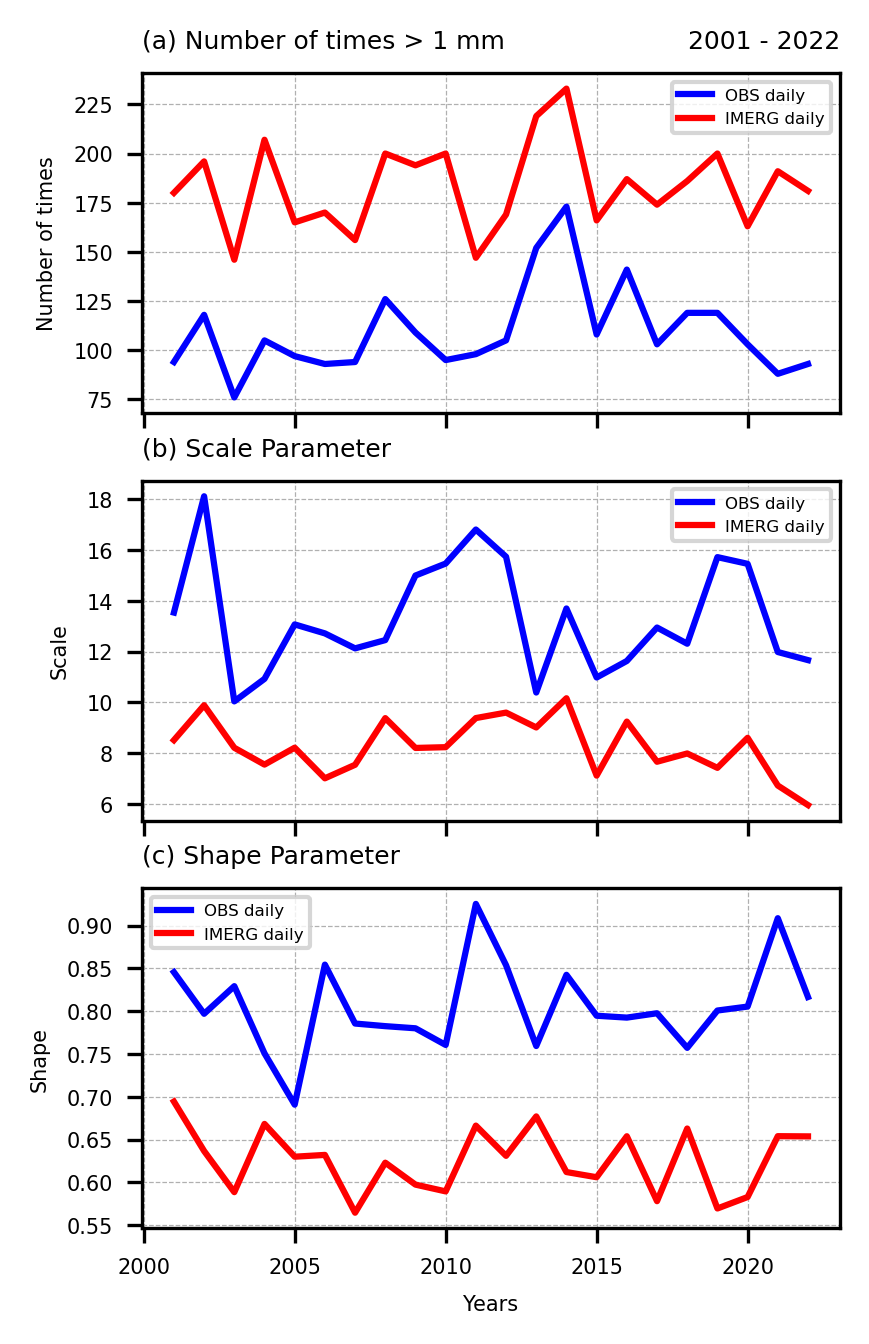

In [19]:
fig = plt.figure(figsize=(3,5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,0], c='b', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,0], c='r', label=f'IMERG daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_ylabel('Number of times', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,1], c='b', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,1], c='r', label=f'IMERG daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticklabels([])

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARS_OBS, NCW_OBS[:,2], c='b', label=f'OBS daily')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,2], c='r', label=f'IMERG daily')
ax1.legend(fontsize=4)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

In [20]:
npix = 5 # default 3
buffer = 0.5*npix*0.1 # To define the limitis of box_3h

thresh = 1

L1 = 10
L0 = 0.0001
# L1 = down.area_lat_long(clat, clon, dx, dx)[0] # in Km

dt = 3 # time scale of the precipitation product [HOURS] (default 3 hours)

target_x = 0.0001 # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

origin_x = 10 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)

cube1size = 5 # lateral size of cube used to decide among how many single pixel average at smallest scale
tmax = 48 # maximum time scale of integration [HOURS]

acf='mar'
opt_method='genetic'

Tr = np.array([5, 10, 20, 50, 80, 100])
Fi = 1-1/Tr
nyears = len(Tr)

tscale = 24

plot = True

In [21]:
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':time_vector}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [22]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

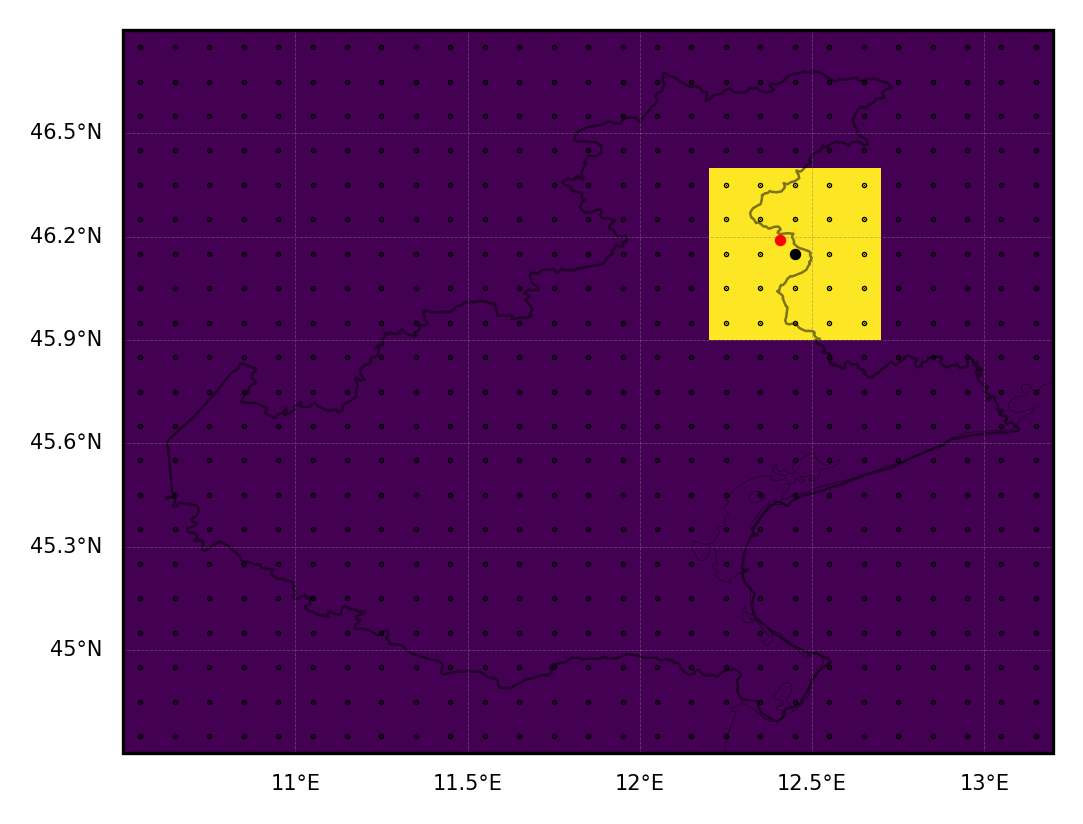

In [23]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, bcond)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=3, c='r', zorder=10)
ax1.scatter(clon, clat, s=3, c='k', zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [24]:
box_3h = xrs.where(bcond, drop = True).load()
box_3h.shape

(5, 5, 64280)

In [25]:
res = {} # initialize dictionary for storing results
xdata = box_3h.where(box_3h >= -0.001) # set negative values to np.nan if any
xdaily0 = xdata.resample(time ='{}h'.format(tscale)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

lons = xdata.lon.values
lats = xdata.lat.values
nlon = np.size(lons)
nlat = np.size(lats)
dx = np.abs(lons[1] - lons[0])

In [26]:
if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
    # otherwise us the one provided by the
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

In [27]:
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

In [28]:
# c_excesses = np.maximum(tsc.values-thresh, 0.0)
c_excesses = tsc.values[tsc.values > thresh] - thresh
NCW = down.wei_fit(c_excesses)
pws = NCW[0]/xdaily.shape[2]
Ns = int(np.floor(pws*365.25)) #Ns = np.int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]

In [29]:
# Taylor Hypothesis for downscaling intermittency
print('Downscaling Intermittency')
taylor = down.downscale_pwet(xdata, thresh=thresh, dt=dt, L1=L1,
                target_x=L0, target_t=tscale,
                origin_x=L1, origin_t=tscale, ninterp=1000, plot=plot)
taylor['beta']

Downscaling Intermittency


0.8672900042294226

In [30]:
print('Downscaling the correlation')
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

Downscaling the correlation


In [36]:
# Correlation downscaling
print('Computing the correlation')
rcorr = down.grid_corr(xdaily, plot=plot, thresh=thresh)
gam_s = down.vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                        rcorr['{}_s'.format(parnames[1])]), acf=acf)

dcorr =  down.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                use_ave=True, opt_method=opt_method, toll=0.005, plot=plot)

differential_evolution step 1: f(x)= 0.0053727831988377665
differential_evolution step 2: f(x)= 0.005226434878904914
differential_evolution step 3: f(x)= 0.005217190487317707
differential_evolution step 4: f(x)= 0.005211917105541509
differential_evolution step 5: f(x)= 0.005211917105541509
differential_evolution step 6: f(x)= 0.005210275646955547
differential_evolution step 7: f(x)= 0.005210275646955547
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [37]:
# downscaling the Weibull pdf
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])

Downscaling pdf - global Weibull parameters


In [38]:
Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, taylor['beta'], par_acf, acf=acf)

In [39]:
print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=maxmiss)
NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, taylor['beta'], par_acf, acf=acf)

Downscaling pdf - yearly Weibull parameters


In [40]:
res['NYs'] = NCWy[:,0] # yearly Weibull parameters
res['CYs'] = NCWy[:,1] # yearly Weibull parameters
res['WYs'] = NCWy[:,2] # yearly Weibull parameters
res['NYd'] = NYd # Nd, Cd, Wd (downscaled parameters)
res['CYd'] = CYd # Nd, Cd, Wd (downscaled parameters)
res['WYd'] = WYd # Nd, Cd, Wd (downscaled parameters)

In [41]:
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)
res['mev_d'] = down.mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability
res['mev_s'] = down.mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability

res['YEARS'] = YEARSy # Add for Arturo

res['gam_d'] = gam_d # variance reduction function downscale
res['gam_s'] = gam_s # variance reduction factor
res['beta'] = taylor['beta'] # ratio between pwet at the grid cell scale () to pwet at the target subgrid scale ()
res['Nd'] = Nd # Nd, Cd, Wd (downscaled parameters)
res['Cd'] = Cd # Nd, Cd, Wd (downscaled parameters)
res['Wd'] = Wd # Nd, Cd, Wd (downscaled parameters)
res['Ns'] = Ns # global Weibull parameters
res['Cs'] = Cs # global Weibull parameters
res['Ws'] = Ws # global Weibull parameters
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w[0] # function value at the end of numerical minimization
res['thresh'] = thresh # threshold used in the analysis
res['clat'] = clat
res['clon'] = clon
if plot:
    res['corr_plot'] = dcorr['fig']
    res['Taylor_contour'] = taylor['contour']

In [42]:
res['beta']

0.8672900042294226

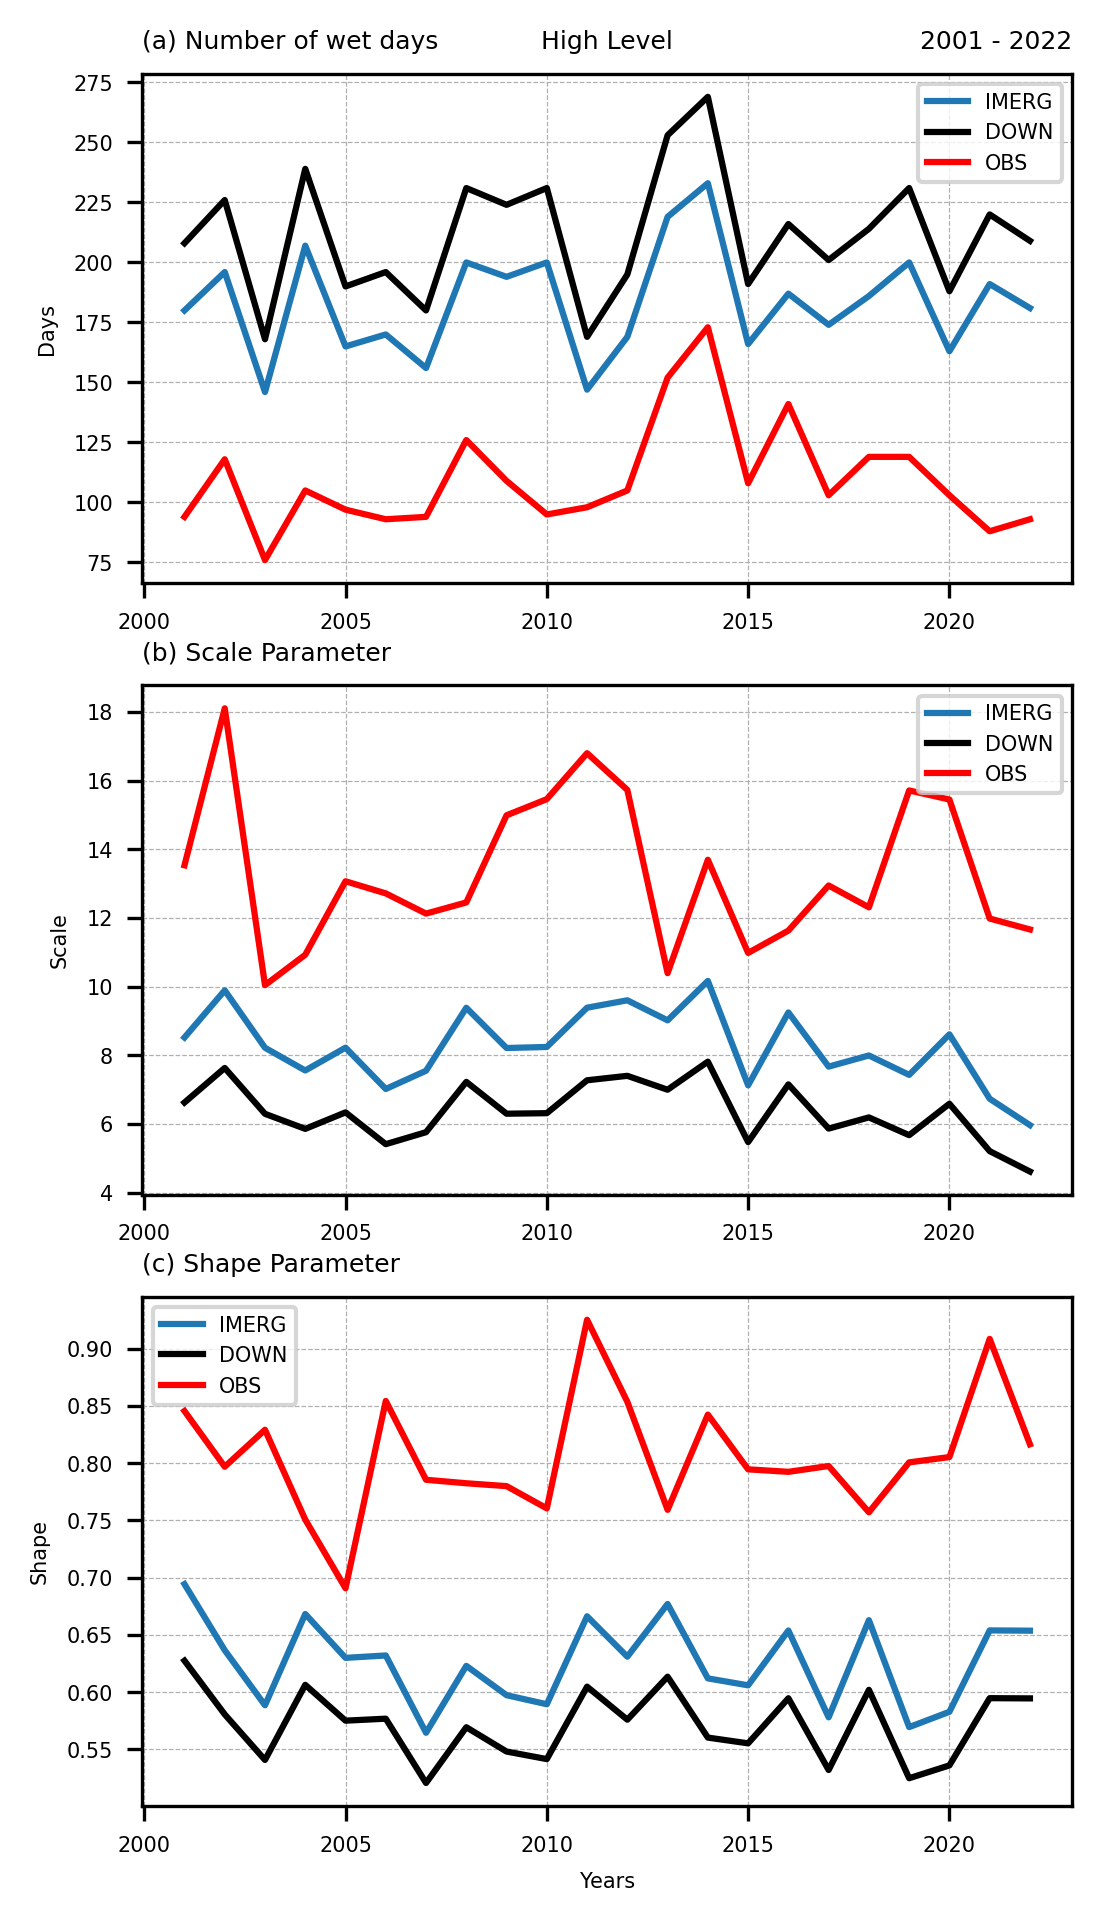

In [43]:
fig = plt.figure(figsize=(4,7.5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARSy, res['NYs'], label=f'IMERG')
ax1.plot(YEARSy, res['NYd'], c='k', label=f'DOWN')
ax1.plot(YEARS_OBS, NCW_OBS[:,0], c='r', label=f'OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of wet days',loc='left',fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)
ax1.set_title(f'{name}',loc='center',fontsize=6)
ax1.set_ylabel('Days', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARSy, res['CYs'], label=f'IMERG')
ax1.plot(YEARSy, res['CYd'], c='k', label=f'DOWN')
ax1.plot(YEARS_OBS, NCW_OBS[:,1], c='r', label=f'OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARSy, res['WYs'], label=f'IMERG')
ax1.plot(YEARSy, res['WYd'], c='k', label=f'DOWN')
ax1.plot(YEARS_OBS, NCW_OBS[:,2], c='r', label=f'OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

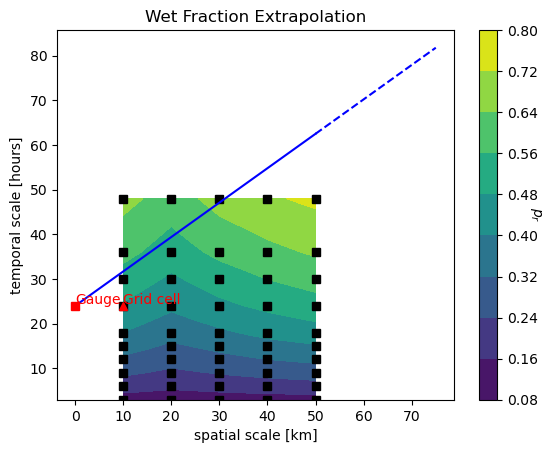

In [45]:
res['Taylor_contour']

In [42]:
# cmap = plt.cm.Spectral_r
# proj = ccrs.PlateCarree()

# fig = plt.figure(figsize=(12,10),dpi=200)
# gs = gridspec.GridSpec(3,3)

# # ============================================================================================================================
# # ============================================================================================================================
# ax1 = plt.subplot(gs[0, 0])

# ax1.plot(YEARS, downres['NYs'], label='IMERG')
# ax1.plot(YEARS, downres['NYd'], label='Downscale')
# ax1.plot(YEARS, NCW_3h[:,0], c='r', label='Raingauge')

# ax1.legend(fontsize=5, loc=2)
# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xticks(YEARS.astype(int)[::3])
# ax1.set_xticklabels(YEARS.astype(int)[::3])
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.set_title('(a) # wet times', loc='left', fontsize=8)
# ax1.set_title(f'{name} station', loc='right', fontsize=8)

# # ==============================================================================================
# ax1 = plt.subplot(gs[1, 0])

# ax1.plot(YEARS, downres['CYs'], label='IMERG')
# ax1.plot(YEARS, downres['CYd'], label='Downscale')
# ax1.plot(YEARS, NCW_3h[:,1], c='r', label='Raingauge')

# ax1.legend(fontsize=5, loc=2)
# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xticks(YEARS.astype(int)[::3])
# ax1.set_xticklabels(YEARS.astype(int)[::3])
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)

# # ==============================================================================================
# ax1 = plt.subplot(gs[2, 0])

# ax1.plot(YEARS, downres['WYs'], label='IMERG')
# ax1.plot(YEARS, downres['WYd'], label='Downscale')
# ax1.plot(YEARS, NCW_3h[:,2], c='r',label='Raingauge')

# ax1.legend(fontsize=5, loc=2)
# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xticks(YEARS.astype(int)[::3])
# ax1.set_xticklabels(YEARS.astype(int)[::3])
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.set_title('(c) Shape parameter', loc='left', fontsize=8)

# # ============================================================================================================================
# # ============================================================================================================================
# max_ref = np.max((np.max(NCW_3h[:,0]), np.max(downres['NYd'])))
# min_ref = np.min((np.min(NCW_3h[:,0]), np.min(downres['NYd'])))
# ax1 = plt.subplot(gs[0, 1])

# ax1.scatter(NCW_3h[:,0], downres['NYd'], c='k', s=18, label='Scatter')
# ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

# slope, intercept, _, _, _ = stats.linregress(NCW_3h[:,0], downres['NYd'])
# ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xlim(min_ref-6, max_ref+6)
# ax1.set_ylim(min_ref-6, max_ref+6)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(d) # wet days (OBS vs DOWN)', loc='left', fontsize=8)
# ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=8)

# # ==============================================================================================
# max_ref = np.max((np.max(NCW_3h[:,1]), np.max(downres['CYd'])))
# min_ref = np.min((np.min(NCW_3h[:,1]), np.min(downres['CYd'])))
# ax1 = plt.subplot(gs[1, 1])

# ax1.scatter(NCW_3h[:,1], downres['CYd'], c='k', s=18, label='Scatter')
# ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

# slope, intercept, _, _, _ = stats.linregress(NCW_3h[:,1], downres['CYd'])
# ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xlim(min_ref-1, max_ref+1)
# ax1.set_ylim(min_ref-1, max_ref+1)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(e) Scale parameter (OBS vs DOWN)', loc='left', fontsize=8)

# # ==============================================================================================
# max_ref = np.max((np.max(NCW_3h[:,2]), np.max(downres['WYd'])))
# min_ref = np.min((np.min(NCW_3h[:,2]), np.min(downres['WYd'])))
# ax1 = plt.subplot(gs[2, 1])

# ax1.scatter(NCW_3h[:,2], downres['WYd'], c='k', s=18, label='Scatter')
# ax1.plot(np.arange(min_ref,max_ref, 0.01),np.arange(min_ref,max_ref, 0.01), '--', color='k', linewidth=0.4, label='Identity line')

# slope, intercept, _, _, _ = stats.linregress(NCW_3h[:,2], downres['WYd'])
# ax1.plot(np.arange(min_ref,max_ref, 0.01), slope*np.arange(min_ref,max_ref, 0.01) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xlim(min_ref-0.02, max_ref+0.02)
# ax1.set_ylim(min_ref-0.02, max_ref+0.02)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(f) Shape parameter (OBS vs DOWN)', loc='left', fontsize=8)

# # ============================================================================================================================
# # ============================================================================================================================
# quant, flags = down.mev_quant(Fi, 0, NCW_3h[:,0], NCW_3h[:,1], NCW_3h[:,2], thresh=1)
# ax1 = plt.subplot(gs[0, 2])
# ax1.plot(Tr, downres['mev_s'], label='IMERG')
# ax1.plot(Tr, downres['mev_d'], label='Downscale')
# ax1.plot(Tr, quant, c='r', label='Raingauge')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(g) Return Time vs Quantile (Annual Rainfall)', loc='left', fontsize=8)

# # ==============================================================================================
# x = np.linspace(0, 200, 1000)
# OBS_N, OBS_scale, OBS_shape = down.wei_fit(OBS_3h['PRE'].values)
# OBS_pdf = weibull_min.pdf(x, OBS_shape, scale=OBS_scale)
# IMERG_pdf = weibull_min.pdf(x, downres['Ws'], scale=downres['Cs'])
# DOWN_pdf = weibull_min.pdf(x, downres['Wd'], scale=downres['Cd'])
# ax1 = plt.subplot(gs[1, 2])
# ax1.plot(x, IMERG_pdf, linewidth=6, label='IMRERG')
# ax1.plot(x, DOWN_pdf, linewidth=3, label='Downscaling')
# ax1.plot(x, OBS_pdf,  c='r', label='Raingauge')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=0)
# ax1.set_title('(h) Weibull Probability Density Function (PDF)', loc='left', fontsize=8)

# # ==============================================================================================
# x = np.linspace(0, 200, 1000)
# OBS_cdf = weibull_min.cdf(x, OBS_shape, scale=OBS_scale)
# IMERG_cdf = weibull_min.cdf(x, downres['Ws'], scale=downres['Cs'])
# DOWN_cdf = weibull_min.cdf(x, downres['Wd'], scale=downres['Cd'])
# ax1 = plt.subplot(gs[2, 2])
# ax1.plot(x, IMERG_cdf, linewidth=6, label='IMRERG')
# ax1.plot(x, DOWN_cdf, linewidth=3, label='Downscaling')
# ax1.plot(x, OBS_cdf,  c='r', label='Raingauge')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=0)
# ax1.set_title('(i) Weibull Cumulative Distribution Function (CDF)', loc='left', fontsize=8)
# # ============================================================================================================================
# # ============================================================================================================================
# plt.subplots_adjust(hspace=0.2,wspace=0.15)

# # salida = os.path.join('..','fig',f'Weibull_parameters_{name.replace(' ','_')}_station.png')
# # print(f'Export figure to: {salida}')
# # plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)